# Training Pipeline

Note that Hopsworks would recommend to split this part of the notebook into a 3 separate files:
1. feature engineering notebook
2. training notebook
3. inferencing notebook

**4. PRÉPARATION DES DONNÉES / PREPARING THE DATA**


Un modèle de machine learning est une équation mathématique. Une équation ne peut accepter autre chose que des chiffres. Vos données catégoriques doivent être donc transformées (encodées) en données numériques à cette étape. Cependant, si vous encodéz les données, vous devez aussi sauvegarder le encodeur pour après décodifier une fois le modèle entraîné

In [2]:
# Install the Hopsworks client library
!pip install --quiet hopsworks

In [3]:
# Connect to the Hopsworks Feature store and get the feature group
import hopsworks
proj = hopsworks.login()
fs = proj.get_feature_store()
fg = fs.get_feature_group(name="car_prices", version=1)

Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) Car_Prices
	 (2) GraphEmbeddingsDemo
	 (3) rixdemo
	 (4) BeerVolumePrediction

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/818324
2024-06-20 15:43:05,895 WARNING: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead

2024-06-20 15:43:05,896 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
# Create a feature view for the training
feature_view = fs.get_or_create_feature_view(name="car_prices",
                                             version=1,
                                             query= fg.select_except(["seller", "saledate"]),
                                             labels=["sellingprice"]
                                             )

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/818324/fs/814147/fv/car_prices/version/1


In [5]:
import pandas as pd

features_df, labels_df = feature_view.training_data()
features_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.51s) 
2024-06-20 15:43:56,165 WARNING: VersionWarning: Incremented version to `1`.



,year,make,model,trim,body,transmission,condition,odometer,color,interior
0,2003,Mercury,Mountaineer,Convenience,SUV,automatic,31.0,86584.0,silver,gray
1,2007,Chevrolet,Tahoe,LT,SUV,automatic,26.0,100833.0,white,gray
2,2001,Acura,TL,3.2,Sedan,automatic,46.0,241875.0,black,black
3,2002,Nissan,Maxima,GLE,Sedan,automatic,28.0,153046.0,gold,tan
4,2011,Toyota,Tacoma,V6,Double Cab,automatic,44.0,57316.0,silver,gray
...,...,...,...,...,...,...,...,...,...,...
70214,2012,Lexus,IS 250,Base,Sedan,automatic,19.0,16837.0,gray,black
70215,2009,Ford,F-350 Super Duty,XL,Crew Cab,manual,25.0,79124.0,white,gray
70216,2003,GMC,Yukon,Denali,SUV,automatic,28.0,146113.0,black,tan
70217,2006,Saab,9-3,Aero,Convertible,automatic,23.0,48079.0,blue,gray


In [7]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
import joblib

def encode_categorical_data(dataset, label_encoders):
    # Itérer sur les colonnes du DataFrame
    for column in dataset.columns:
        # Vérifier si la colonne est de type 'object' (catégorique)
        if dataset[column].dtype == 'object':
            # Créer une instance de LabelEncoder
            label_encoder = LabelEncoder()

            # Effectuer l'encodage sur les valeurs uniques de la colonne
            dataset[column] = label_encoder.fit_transform(dataset[column])

            # Ajouter le label encoder au dictionnaire
            label_encoders[column] = label_encoder
    return dataset

# Créer un dictionnaire pour stocker les label encoders
clf = {}
df_encoded = encode_categorical_data(features_df, clf)
df_encoded

,year,make,model,trim,body,transmission,condition,odometer,color,interior
0,2003,31,403,412,31,0,31.0,86584.0,15,6
1,2007,7,578,657,31,0,26.0,100833.0,17,6
2,2001,0,572,167,32,0,46.0,241875.0,1,1
3,2002,33,382,540,32,0,28.0,153046.0,6,13
4,2011,45,577,1057,11,0,44.0,57316.0,15,6
...,...,...,...,...,...,...,...,...,...,...
70214,2012,24,302,321,32,0,19.0,16837.0,7,1
70215,2009,12,225,1129,9,1,25.0,79124.0,17,6
70216,2003,13,654,429,31,0,28.0,146113.0,1,13
70217,2006,39,33,302,7,0,23.0,48079.0,2,6


Transforme les valeurs categoriques du dataset 'dataset_cleaned.csv' en valeurs numériques et sauvegarde l'encodeur dans un fichier pour une utilisation ultérieure lors de la prediction


Coupe le dataset encodé en deux parties, train et test Garde 1000 données dans le dataset de test`

In [8]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df_encoded, labels_df, test_size=1000, random_state=42)

# Afficher les tailles des ensembles d'entraînement et de test
print("Taille de l'ensemble d'entraînement :", len(X_train))
print("Taille de l'ensemble de test :", len(X_test))

Taille de l'ensemble d'entraînement : 69219
Taille de l'ensemble de test : 1000


**5. ENTRAÎNEMENT DU MODÈLE / TRAINING OF THE MODEL**

Entraîne un modèle de régression utilisant une architecture de neurones profondes. La colonne à calculer est "sellingprice". Utilise la fonction de perte mean absolute error et la librairie pytorch

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Conversion des données en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Création des ensembles de données
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Définition du modèle
class DeepRegressor(nn.Module):
    def __init__(self, input_size):
        super(DeepRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialisation du modèle
model = DeepRegressor(input_size=X_train_tensor.shape[1])

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 50
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Évaluation du modèle
model.eval()
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


2024-06-20 15:46:46,522 WARNING: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

2024-06-20 15:46:47,438 WARNING: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Epoch 1/50, Loss: 7127.2606
Epoch 2/50, Loss: 6952.0914
Epoch 3/50, Loss: 6948.0117
Epoch 4/50, Loss: 6947.5265
Epoch 5/50, Loss: 6940.9662
Epoch 6/50, Loss: 6935.2531
Epoch 7/50, Loss: 6932.5907
Epoch 8/50, Loss: 6932.8072
Epoch 9/50, Loss: 6932.3879
Epoch 10/50, Loss: 6929.1544
Epoch 11/50, Loss: 6927.8142
Epoch 12/50, Loss: 6931.5428
Epoch 13/50, Loss: 6928.9794
Epoch 14/50, Loss: 6928.9452
Epoch 15/50, Loss: 6928.2130
Epoch 16/50, Loss: 6930.2998
Epoch 17/50, Loss: 6924.2025
Epoch 18/50, Loss: 692

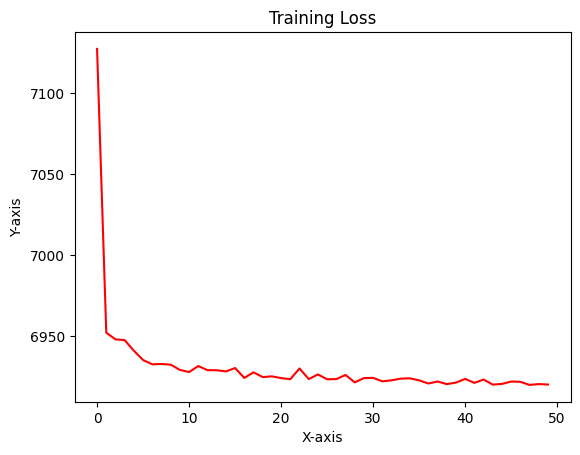

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Training Loss')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.plot(np.array(losses), 'r')
plt.show()

Pour minimiser l'erreur n'hesitez pas à :

1. Tester des architectures neuronales différentes (plus de couches de neurones)
2. Changer les hyper paramètres (plus d'epochs, autre learning rate, etc)
3. Normaliser vos données avant l'entraînement lors de la phase de préparation de la donnée. Si vous le faites, n'oubliez pas de revenir à l'échelle (dénormaliser) avant de faire des prédictions.

**6. SAUVEGARDE DU MODÈLE DANS UN FICHIER POUR UTILISATION ULTÈRIEURE**

**6. SAVE THE MODEL TO A FILE FOR LATER USE**

Sauvegarde le modèle entier entraîné dans un fichier pour l'utiliser après et le mettre en production

In [12]:
# This step will upload the model to the Hopsworks Model Registry

import os
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib

input_schema = Schema(features_df)
output_schema = Schema(labels_df)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_name = "car_prices"

os.makedirs(model_name + "/images", exist_ok=True)

plt.savefig(model_name + "/images/training_losses.png")
plt.close()
# Sauvegarder le modèle
torch.save(model, model_name + '/modele_regresseur.pth')
joblib.dump(clf, model_name + '/label_encoders.pkl')

mr = proj.get_model_registry()

car_prices_model = mr.torch.create_model(
    model_name,
    model_schema=model_schema,
    metrics = {'test_loss' : test_loss}
)

# Save the created model in the "lending_model" directory
car_prices_model.save(model_name)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/23468 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/38202 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2396 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/865 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/818324/models/car_prices/1


Model(name: 'car_prices', version: 1)

Now we can proceed to the Inference Pipeline of the workshop demo example.